In [1]:
pip install pennylane --upgrade

Requirement already up-to-date: pennylane in /Users/amelieschreiber/anaconda3/lib/python3.7/site-packages (0.7.0)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pennylane-sf pennylane-qiskit pennylane-cirq pennylane-forest pennylane-qsharp

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install autograd tensorflow>=1.13.2

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install -U scikit-learn

Requirement already up-to-date: scikit-learn in /Users/amelieschreiber/anaconda3/lib/python3.7/site-packages (0.22)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

In [6]:
from sklearn.datasets import make_moons
from matplotlib import pyplot
from pandas import DataFrame

# generate 2d classification dataset
# X, y = make_moons(n_samples=500, noise=0.1)
# scatter plot, dots colored by class value
# df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
# colors = {0:'red', 1:'blue'}
# fig, ax = pyplot.subplots()
# grouped = df.groupby('label')
# for key, group in grouped:
    # group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
# pyplot.show()

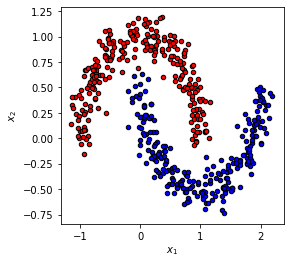

In [7]:
def plot_data(x, y, fig=None, ax=None):
    """
    Plot data with red/blue values for a binary classification.

    Args:
        x (array[tuple]): array of data points as tuples
        y (array[int]): array of data points as tuples
    """
    if fig == None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    reds = y == 0
    blues = y == 1
    ax.scatter(x[reds, 0], x[reds, 1], c="red", s=20, edgecolor="k")
    ax.scatter(x[blues, 0], x[blues, 1], c="blue", s=20, edgecolor="k")
    ax.set_xlabel("$x_1$")
    ax.set_ylabel("$x_2$")


Xdata, ydata = make_moons(500, noise = 0.1)
fig, ax = pyplot.subplots(1, 1, figsize=(4, 4))
plot_data(Xdata, ydata, fig=fig, ax=ax)
pyplot.show()

In [8]:
# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T


label_0 = [[1], [0]]
label_1 = [[0], [1]]
state_labels = [label_0, label_1]

In [9]:
dev = qml.device("default.qubit", wires=1)

In [10]:
@qml.qnode(dev)
def qcircuit(params, x=None, y=None):
    """A variational quantum circuit representing the Universal classifier.

    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    for p in params:
        qml.Rot(*x, wires=0)
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))

In [11]:
def fidelity(state1, state2):
    """
    Calculates the fidelity between two state vectors

    Args:
        state1 (array[float]): State vector representation
        state2 (array[float]): State vector representation

    Returns:
        float: fidelity between `state1` and `state2`
    """
    return np.abs(np.dot(np.conj(state1), state2))

In [12]:
def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        f = qcircuit(params, x=x[i], y=dm_labels[y[i]])
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [13]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    output_states = []
    dm_labels = [density_matrix(s) for s in state_labels]
    for i in range(len(x)):
        expectation = qcircuit(params, x=x[i], y=dm_labels[y[i]])
        output_states.append(dev._state)
    predicted = predicted_labels(output_states, state_labels)
    return predicted, output_states

In [14]:
def predicted_labels(states, state_labels=None):
    """
    Computes the label of the predicted state by selecting the one
    with maximum fidelity.

    Args:
        weights (array[float]): array of weights
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    output_labels = [np.argmax([fidelity(s, label) for label in state_labels]) for s in states]
    return np.array(output_labels)

In [15]:
def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)

In [16]:
def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]

## Generate Training Data

In [17]:
# Generate training and test data
num_training = 200
num_test = 2000

Xdata, y_train = make_moons(num_training, noise=0.1)
X_train = np.hstack((Xdata, np.zeros((Xdata.shape[0], 1))))

Xtest, y_test = make_moons(num_test, noise=0.1)
X_test = np.hstack((Xtest, np.zeros((Xtest.shape[0], 1))))

In [18]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 20
batch_size = 32

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)

# initialize random weights
params = np.random.uniform(size=(num_layers, 3))

predicted_train, states_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, states_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test Accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, states_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, states_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print("Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(*res))

Epoch:  0 | Cost: 0.476878 | Train accuracy: 0.350000 | Test Accuracy: 0.334000
Epoch:  1 | Loss: 0.137673 | Train accuracy: 0.870000 | Test accuracy: 0.873500
Epoch:  2 | Loss: 0.087573 | Train accuracy: 0.860000 | Test accuracy: 0.886000
Epoch:  3 | Loss: 0.072570 | Train accuracy: 0.960000 | Test accuracy: 0.966000
Epoch:  4 | Loss: 0.071946 | Train accuracy: 0.885000 | Test accuracy: 0.901500
Epoch:  5 | Loss: 0.066232 | Train accuracy: 0.955000 | Test accuracy: 0.952000
Epoch:  6 | Loss: 0.062659 | Train accuracy: 0.925000 | Test accuracy: 0.917500
Epoch:  7 | Loss: 0.060870 | Train accuracy: 0.920000 | Test accuracy: 0.937500
Epoch:  8 | Loss: 0.060230 | Train accuracy: 0.935000 | Test accuracy: 0.927500
Epoch:  9 | Loss: 0.059541 | Train accuracy: 0.920000 | Test accuracy: 0.936000
Epoch: 10 | Loss: 0.059129 | Train accuracy: 0.920000 | Test accuracy: 0.931500
Epoch: 11 | Loss: 0.058731 | Train accuracy: 0.940000 | Test accuracy: 0.938000
Epoch: 12 | Loss: 0.058635 | Train accur

Cost: 0.058234 | Train accuracy 0.925000 | Test Accuracy : 0.936500
Learned weights
Layer 0: [3.3271258  1.85030305 2.75902767]
Layer 1: [-1.56388984 -1.17505077  0.65990497]
Layer 2: [ 1.43235029 -0.82002049  0.74256468]


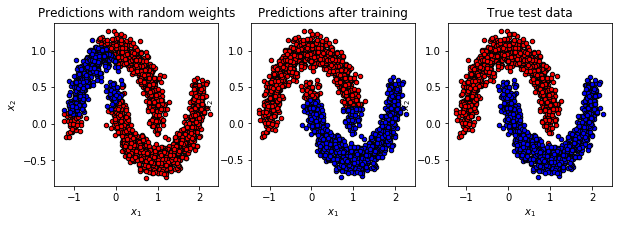

In [19]:
print(
    "Cost: {:3f} | Train accuracy {:3f} | Test Accuracy : {:3f}".format(
        loss, accuracy_train, accuracy_test
    )
)

print("Learned weights")
for i in range(num_layers):
    print("Layer {}: {}".format(i, params[i]))


fig, axes = pyplot.subplots(1, 3, figsize=(10, 3))
plot_data(X_test, initial_predictions, fig, axes[0])
plot_data(X_test, predicted_test, fig, axes[1])
plot_data(X_test, y_test, fig, axes[2])
axes[0].set_title("Predictions with random weights")
axes[1].set_title("Predictions after training")
axes[2].set_title("True test data")
pyplot.show()